# MFD CHUUUUUUK

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [66]:
def get_lane_length(csv_lanelength): #get lane length information
    lanelength_data = pd.read_csv(csv_lanelength, skiprows=1, header=None)
    lane_list = lanelength_data[0]
    length_list = lanelength_data[1]/1000
    #store in dictionary : 
    lane_length = dict(zip(lane_list,length_list))
    return lane_length

In [67]:
def get_data_group(csv_flow_and_density): #grouping data to pandas object
    #get flow(veh/hr) and density(veh/km) in each lane for certain interval 
    flowdensity = pd.read_csv(csv_flow_and_density, header=0, sep=';')

    #only for get a list of 'time' in mfd-data.csv
    flowdensity_lane = flowdensity.groupby('lane_ids')
    dummy_group = flowdensity_lane.get_group('1_0')
    time_list = dummy_group['time']

    #real grouping (group by time)
    flowdensity_time = flowdensity.groupby('time')
    return time_list, flowdensity_time

In [68]:
def get_MFD_property(time_list, flowdensity_time,total_lane_length,lane_length_dict): #calculate Qt and Kt
    Q = [] #list of network flow
    K = [] #list of network density
    #calculate network flow (Qt) and network density(Kt)
    for time in time_list[::]:
        the_group = flowdensity_time.get_group(time)
        lane_ids = the_group['lane_ids']
        lane_flows = the_group['outflow']
        lane_densities = the_group['laneDensity']
        flowx = []
        densityx= []
        #bisa dibenerin tanpa enumerate 
        for i,lane in enumerate(lane_ids):
            lane_id = lane_ids.iloc[i]
            lane_flow = lane_flows.iloc[i]
            lane_density = lane_densities.iloc[i]
            lane_length = lane_length_dict[str(lane_id)] #get lane length from earlier dictionary in lane-length.csv
        
            flowxlength = lane_flow*lane_length
            flowx.append(flowxlength) #list
            densityxlength = lane_density*lane_length
            densityx.append(densityxlength) #list
        Qt = sum(flowx)/total_lane_length
        Kt = sum(densityx)/total_lane_length
        Q.append(Qt)
        K.append(Kt)
    return Q, K

In [69]:
def convert(n):
    return str(datetime.timedelta(seconds = n))

In [70]:
csv_lanelength = 'lane-length-new.csv'
csv_list = ['mfd-data-dqn-boltzman-min-exponen-K=25.csv']
# csv_list = ['Tes_DQN_1.csv']

lane_length_dict = get_lane_length(csv_lanelength)
total_lane_length = sum(lane_length_dict.values()) #total lane length in network (KM)

In [71]:
time_list = {}
flowdensity_time = {}
Qn = {}
Kn = {}

for csv in csv_list:
    time_list[csv], flowdensity_time[csv] = get_data_group(csv)
    Qn[csv], Kn[csv] = get_MFD_property(time_list[csv],flowdensity_time[csv],total_lane_length,lane_length_dict)

In [72]:
time_list_hr = {}
for csv in csv_list:
    time_list_hr[csv] = [0]

for csv in csv_list :
    for time_s in time_list[csv] :
        time_list_hr[csv].append(convert(time_s))

for csv in csv_list:
    time_list_hr[csv].pop(0)


list_interval = 2
ticks_list = [str(n)+':00:00' for n in range(6,24,list_interval)]

ticks_list_y = [d for d in range(0,250,50)]

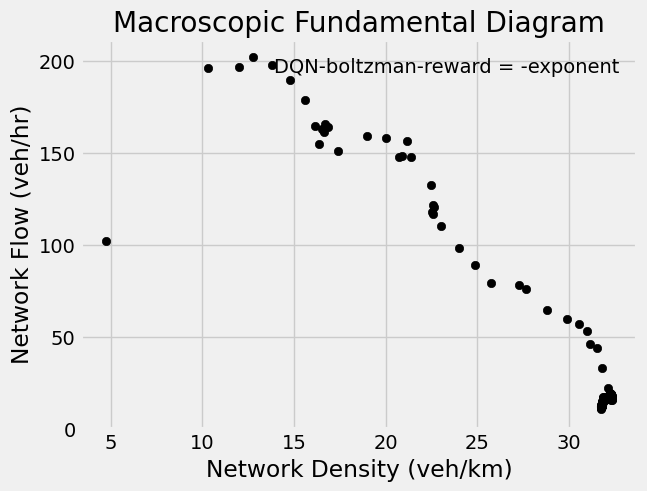

In [73]:
plt.style.use('fivethirtyeight')

plt.scatter(Kn['mfd-data-dqn-boltzman-min-exponen-K=25.csv'],Qn['mfd-data-dqn-boltzman-min-exponen-K=25.csv'],color='black',label='DQN-boltzman-reward = -exponent') # K = 25
# plt.scatter(Kn['Tes_DQN_1.csv'],Qn['Tes_DQN_1.csv'],color='black',label='DQN-boltzman-reward = -exponent') # K = 25

plt.yticks(ticks_list_y)
plt.title('Macroscopic Fundamental Diagram')
plt.xlabel('Network Density (veh/km)')
plt.ylabel('Network Flow (veh/hr)')
plt.legend(loc='upper right', frameon=False)
plt.show()